# Step 3: Data Analysis

__Tools__: Analysis will be done in python, using a number of useful open source python packages:

- __Pandas__ A very useful data analysis and manipulation package http://pandas.pydata.org/
- __Numpy__ Python's scientific computing package. http://www.numpy.org/
- __Statsmodels__ is a module that provides classes and functions for the estimation of many different statistical models. https://www.statsmodels.org/

All these packages come bundled as part of the Anaconda python distribution. Install Anaconda for the simplest way to get all dependancies for the tutorial: __Anaconda__ https://www.anaconda.com/download/

Let's get started by importing the raw data and libraries we will use.

In [1]:
import pandas as pd
import numpy as np

# Import Dataframe and add the date columns
Now, the data is more manageable and we can work with it.


In [2]:
# DataFrame is imported as a csv from the wrangling and made into a dataframe with the date as index
df = pd.read_csv('mortality.csv', parse_dates = ['date'])
df = df.set_index(df.date)

# Adding year, month, day as columns in the dataframe
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day

df.head()

,date,deaths,year,month,day
date,,,,,
2015-01-01,2015-01-01,107,2015,1,1
2015-01-02,2015-01-02,101,2015,1,2
2015-01-03,2015-01-03,78,2015,1,3
2015-01-04,2015-01-04,121,2015,1,4
2015-01-05,2015-01-05,99,2015,1,5


# Making dictionaries from estimates and adding it to our data set
The website https://simplystatistics.org/2018/06/08/a-first-look-at-recently-released-official-puerto-rico-death-count-data/ includes estimates from Teralytics and estimates of population by year. 

In [3]:
# population from yearly data and data sampled from Teralytics estimates by author 
# this is made into a dictionary 
samples = {
    '2010-07-02': 3721525,
    '2011-07-02': 3678732,
    '2012-07-02': 3634488,
    '2013-07-02': 3593077,
    '2014-07-02': 3534874,
    '2015-07-02': 3473177,
    '2016-07-02': 3406520,
    '2017-07-02': 3337177,
    
    '2017-09-19': 3337000,
    '2017-10-15': 3237000,
    '2017-11-15': 3202000,
    '2017-12-15': 3200000,
    '2018-01-15': 3223000,
    '2018-02-15': 3278000
}

# add the above data points to our data set
# turn the dictionary into a datafrane and add it into the original data frame
# index is date and the column is est_pop
pdf = pd.DataFrame.from_dict(samples, orient='index', columns=['est_pop'])
pdf = pdf.set_index(pd.to_datetime(pdf.index))
pdf.est_pop = pdf.est_pop.astype(int)

df = df.join(pdf)

# Linear interpolation of estimated population
Linear interpolation is a method of curve fitting using linear polynomials to construct new data points within the range of a discrete set of known data points. This estimate is used to graph.

In [4]:
# linear interpolation is method of curve fitting using linear polynomials to construct 
# new data points within the range of a discrete set of known data points 
df['est_pop_lerped'] = df.est_pop.interpolate(limit_direction='both')


# Calculating Rate
Using days prior to sept 20th to calculate yearly median death rate.

In [5]:
# made a copy of the dataframe
rdf = df.copy()

# the article says only to use days prior to sept 20th in calcualting yearly median death rate
rdf = rdf[rdf['date'].dt.dayofyear < 263] # sept 20th is 263rd day of year 

# calculating calc_rate
rdf['calc_rate'] = rdf.deaths / rdf.est_pop_lerped * 365 * 1000
rdf.groupby('year').median() 

,deaths,month,day,est_pop,est_pop_lerped,calc_rate
year,,,,,,
2015,78.0,5.0,15.0,3473177.0,3.473177e+06,8.197106
2016,78.5,5.0,15.0,3406520.0,3.416081e+06,8.387468
2017,80.0,5.0,15.0,3337088.5,3.346961e+06,8.750266
2018,66.0,5.0,15.0,3250500.0,3.278000e+06,7.348993


# Calculating yearly rates
Now, we use the data given to us by the page previously mentioned and add it into our dataframe.

In [6]:
# Dictionary given by the original website
yearly_rates = {
    2015: 8.197106,
    2016: 8.387468,
    2017: 8.750266,
    2018: 8.750266 # this is assumed same as 2017 from above result
}

# yrdf= yearly rates data frame
# turn the dictionary into a data frame and add to dataframe
yrdf = pd.DataFrame.from_dict(yearly_rates, orient='index', columns=['year_rate'])
df = df.join(yrdf, on='year')

# Calculate day rate
Adding a daily rate column calculating the death rate across the entire dataset.

In [7]:
# recalculate death rate across entire dataset
df['day_rate'] = df.deaths / df.est_pop_lerped * 365 * 1000

# Clean up population columns
Cleaning up the columns to make it more manageable.

In [8]:
# clean up population columns
df = df.drop('est_pop', axis=1)
df = df.rename({"est_pop_lerped": "pop"}, axis=1)
df.head()

,date,deaths,year,month,day,pop,year_rate,day_rate
date,,,,,,,,
2015-01-01,2015-01-01,107,2015,1,1,3473177.0,8.197106,11.244748
2015-01-02,2015-01-02,101,2015,1,2,3473177.0,8.197106,10.614201
2015-01-03,2015-01-03,78,2015,1,3,3473177.0,8.197106,8.197106
2015-01-04,2015-01-04,121,2015,1,4,3473177.0,8.197106,12.716023
2015-01-05,2015-01-05,99,2015,1,5,3473177.0,8.197106,10.404019


# Calculate day rate and average rate

In [9]:
adf = df.query('year < 2017 and not (month == 2 and day == 29)')
ardf = adf.groupby(['month', 'day'], as_index=False).apply(lambda x: (x.day_rate - x.year_rate).mean())
ardf = ardf.to_frame(name='avg_rate')
ajdf = adf.merge(ardf, on=['month', 'day'])

adf = ajdf 
adf.plot(x='date', y='avg_rate', style='.')

# Average rate smoothed
Using lowess to calculate the average rate.

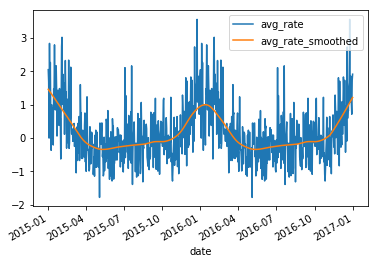

In [10]:
# Need to run and use lowess to smoothen out graph
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

smdf = adf
smdf['avg_rate_smoothed'] = lowess(adf.avg_rate, adf.date, frac=0.15, it=3, return_sorted=False)
smdf.plot(x='date', y=['avg_rate', 'avg_rate_smoothed'])

# Calculate trend
Merge some columns and add it to a new dataframe that includes all the data.

/home/angelsan720/miniconda3/envs/datascience/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


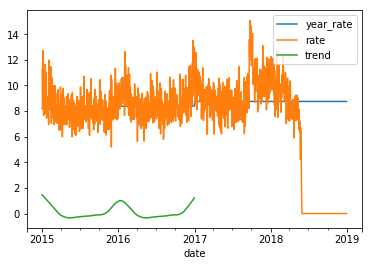

In [11]:
# Merging and renaming
full = pd.merge(df, smdf[['date', 'avg_rate', 'avg_rate_smoothed']], on='date', how='left')
full = full.set_index(pd.to_datetime(full.date))

full = full.rename({"avg_rate_smoothed": "trend", "day_rate": "rate"}, axis=1)

# TODO: remove this
full.plot(x='date', y=['year_rate', 'rate', 'trend'])

# Annual trend
Calculate annual trend using the data from 2015.

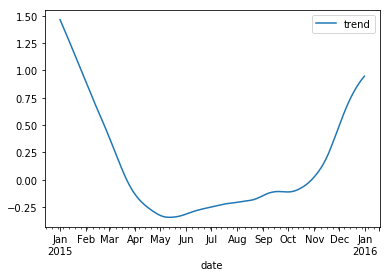

In [12]:
# copy annual trend to 2017-18
ann_trend = full.loc[full["date"].dt.year == 2015, "trend"]
ann_trend # how to copy to 2017-18??
ann_trend = pd.DataFrame(ann_trend)
ann_trend.plot()